## Web Crawling
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

# 동적페이지 수집

### Crawling Naver Stock Data
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : url
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [1]:
import warnings
warnings.filterwarnings('ignore') # 경고문구 제거

import requests
import pandas as pd

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [2]:
page_size, page = 30, 1
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}'
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=30&page=1'

#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
response.text[:200]

'[{"localTradedAt":"2024-03-18","closePrice":"2,685.84","compareToPreviousClosePrice":"19.00","compareToPreviousPrice":{"code":"2","text":"상승","name":"RISING"},"fluctuationsRatio":"0.71","openPrice":"2'

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [5]:
data = response.json() # 문자열 데이터를 리스트안에 딕셔너리로 바꿔줌
data[:2]

[{'localTradedAt': '2024-03-18',
  'closePrice': '2,685.84',
  'compareToPreviousClosePrice': '19.00',
  'compareToPreviousPrice': {'code': '2', 'text': '상승', 'name': 'RISING'},
  'fluctuationsRatio': '0.71',
  'openPrice': '2,678.52',
  'highPrice': '2,688.07',
  'lowPrice': '2,665.28'},
 {'localTradedAt': '2024-03-15',
  'closePrice': '2,666.84',
  'compareToPreviousClosePrice': '-51.92',
  'compareToPreviousPrice': {'code': '5', 'text': '하락', 'name': 'FALLING'},
  'fluctuationsRatio': '-1.91',
  'openPrice': '2,701.91',
  'highPrice': '2,705.59',
  'lowPrice': '2,666.84'}]

In [6]:
 pd.DataFrame(data).head()

,localTradedAt,closePrice,compareToPreviousClosePrice,compareToPreviousPrice,fluctuationsRatio,openPrice,highPrice,lowPrice
0,2024-03-18,"2,685.84",19.00,"{'code': '2', 'text': '상승', 'name': 'RISING'}",0.71,"2,678.52","2,688.07","2,665.28"
1,2024-03-15,"2,666.84",-51.92,"{'code': '5', 'text': '하락', 'name': 'FALLING'}",-1.91,"2,701.91","2,705.59","2,666.84"
2,2024-03-14,"2,718.76",25.19,"{'code': '2', 'text': '상승', 'name': 'RISING'}",0.94,"2,698.37","2,718.76","2,696.31"
3,2024-03-13,"2,693.57",11.76,"{'code': '2', 'text': '상승', 'name': 'RISING'}",0.44,"2,694.71","2,701.45","2,679.54"
4,2024-03-12,"2,681.81",21.97,"{'code': '2', 'text': '상승', 'name': 'RISING'}",0.83,"2,673.47","2,686.14","2,659.72"


In [7]:
data = response.json() # 문자열 데이터를 리스트안에 딕셔너리로 바꿔줌

columns = ["localTradedAt", "closePrice"]
kospi_df = pd.DataFrame(data)[columns]
kospi_df.tail(2)

,localTradedAt,closePrice
28,2024-02-02,"2,615.31"
29,2024-02-01,"2,542.46"


#### 4. 함수로 만들기

In [8]:
def stock_price(code='KOSPI', page_size=60, page=1): # 페이지 60넘으면 차단 네이버
    # 1 url 찾기
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}'
    # https://m.stock.naver.com/api/index/KOSDAQ/price?pageSize=10&page=2 # ㅋ스닥
    
    # 2 request(url) -> response: json(str)
    response = requests.get(url)
    
    # 3 json(str) -> list, dict -> dataframe
    data = response.json()
    columns = ["localTradedAt", "closePrice"]
    return pd.DataFrame(data)[columns]
    # return pd.DataFrame(response.json())[["localTradedAt", "closePrice"]]

In [9]:
df = stock_price(code='KOSDAQ')
df.tail(2)

,localTradedAt,closePrice
58,2023-12-19,858.30
59,2023-12-18,850.96


#### 5. 원달러 환율 데이터 수집 : 실습

In [54]:
# 1 url 찾기 #핵심단계★
code, page, page_size = 'FX_USDKRW', 1, 30
url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?category=exchange&reutersCode={code}&page={page}&pageSize={page_size}'
# &pageSize=60 # 추가해보기 상상력!

# 2 request(url) -> response: json(str)
response = requests.get(url)
# response # 200 확인

# 3 json(str) -> list, dict -> dataframe
data = response.json()['result']
# data

usd_df=pd.DataFrame(data)[["localTradedAt", "closePrice"]]
usd_df.tail(2)


,localTradedAt,closePrice
28,2024-02-02,"1,338.50"
29,2024-02-01,"1,332.00"


#### 6. 시각화

In [12]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# 데이터 수집
kospi_df = stock_price(page_size=30)
kosdaq_df = stock_price("KOSDAQ", page_size=30)

In [15]:
usd_df.tail()

,localTradedAt,closePrice
25,2024-02-07,"1,327.50"
26,2024-02-06,"1,330.00"
27,2024-02-05,"1,335.50"
28,2024-02-02,"1,338.50"
29,2024-02-01,"1,332.00"


In [16]:
kospi_df.tail()

,localTradedAt,closePrice
25,2024-02-07,"2,609.58"
26,2024-02-06,"2,576.20"
27,2024-02-05,"2,591.31"
28,2024-02-02,"2,615.31"
29,2024-02-01,"2,542.46"


In [17]:
kosdaq_df.tail()

,localTradedAt,closePrice
25,2024-02-07,811.92
26,2024-02-06,807.03
27,2024-02-05,807.99
28,2024-02-02,814.77
29,2024-02-01,798.73


In [18]:
df.dtypes

localTradedAt    object
closePrice       object
dtype: object

In [42]:
df2 = kospi_df.copy()
df2.columns = ['date', 'kospi']
df2['kosdaq'] = kosdaq_df['closePrice'].astype('float')
df2['usd'] = usd_df['closePrice'].apply(lambda data : data.replace(',','')).astype('float') # , 있어서 astype 안됨 / apply로 하기
df2['kospi'] = kospi_df['closePrice'].apply(lambda data : data.replace(',','')).astype('float')
df2.tail(2)

#?

,date,kospi,kosdaq,usd
28,2024-02-02,2615.31,814.77,1338.5
29,2024-02-01,2542.46,798.73,1332.0


In [43]:
df2.dtypes

date       object
kospi     float64
kosdaq    float64
usd       float64
dtype: object

In [21]:
# lamda 함수
# 일회용 함수  : 간단한 파라미터와 리턴코드로 되어있는 함수를 대체
# 함수 : 변수 2개 선언 => 메모리 2칸사용

def plus(n1, n2):
    return n1+n2

def calc(func, n1, n2):
    return func(n1, n2)

calc(plus, 1, 2)

3

In [22]:
plus_lambda = lambda n1, n2 : n1+n2
plus_lambda(1, 2)

3

In [23]:
# lambda 메모리 1칸사용
def calc(func, n1, n2):
    return func(n1, n2)

calc(lambda n1, n2 : n1+n2, 1, 2)

3

In [24]:
df.tail(1)

,date,kospi,kosdaq,usd
29,2024-02-01,2542.46,798.73,1332.00


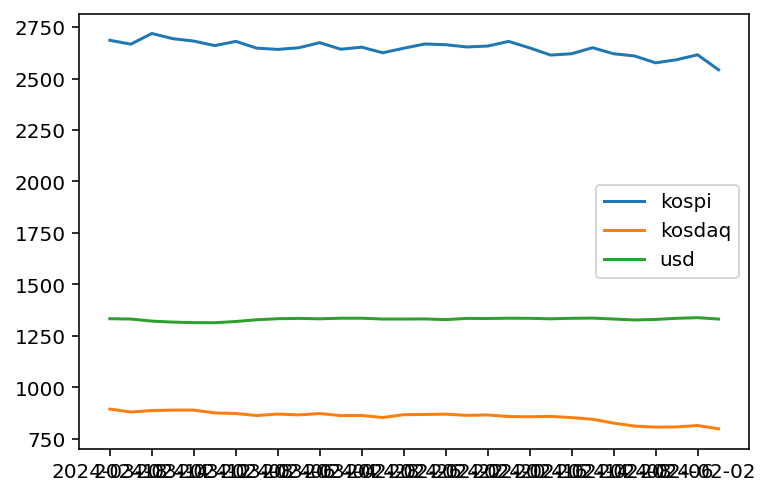

In [44]:
df2=df[::-1] # 날짜 역순으로 ##
plt.plot(df['date'], df['kospi'], label='kospi')
plt.plot(df['date'], df['kosdaq'], label='kosdaq') 
plt.plot(df['date'], df['usd'], label='usd')
plt.legend()
plt.xticks(df['date'][::2])
plt.show()

#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [26]:
from sklearn.preprocessing import minmax_scale

In [39]:
minmax_scale(df2['kospi']) ##

array([0.        , 0.41321611, 0.27708452, 0.19137833, 0.38071469,
       0.44163358, 0.60794101, 0.44220079, 0.40465116, 0.60294952,
       0.78162223, 0.65416903, 0.6287578 , 0.69092456, 0.71038003,
       0.59342031, 0.46846285, 0.62297221, 0.56664776, 0.74764606,
       0.60657969, 0.56171299, 0.59648327, 0.78213273, 0.66579694,
       0.79041407, 0.85711855, 1.        , 0.70550199, 0.81327283])

#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [46]:
df2[ df2.columns[1:] ].corr()

,kospi,kosdaq,usd
kospi,1.000000,0.890528,-0.379493
kosdaq,0.890528,1.000000,-0.382133
usd,-0.379493,-0.382133,1.000000
